<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/misc_examples/SimulateImpScores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install modisco

     |████████████████████████████████| 215 kB 5.4 MB/s 
     |████████████████████████████████| 1.4 MB 45.1 MB/s 
     |████████████████████████████████| 3.2 MB 41.6 MB/s 
  Created wheel for modisco: filename=modisco-0.5.15.0-py3-none-any.whl size=231925 sha256=af44ba625173724206d772fbe524c054afb6cb3374cb91154e2021c0d17da435
  Stored in directory: /root/.cache/pip/wheels/67/53/04/50094050522f2faf148096dd88651c1674c3c7a619a5c5377a
Successfully built modisco


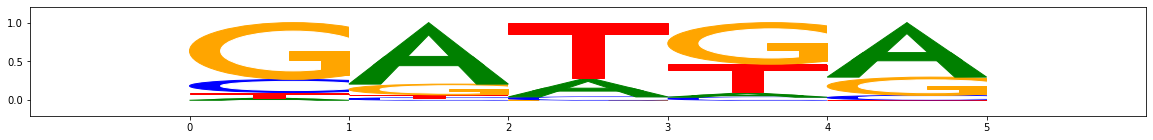

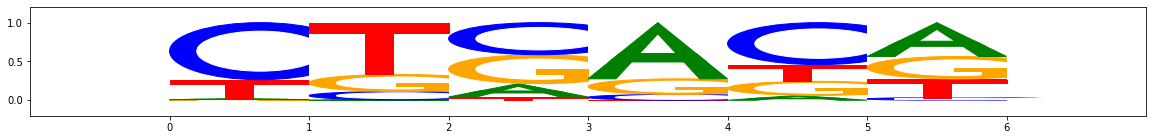

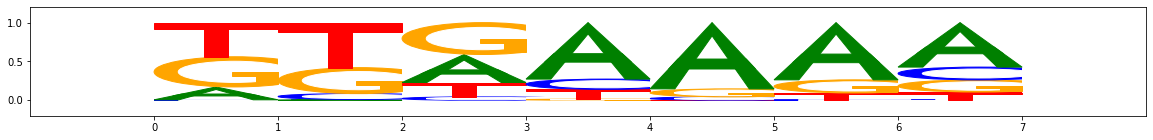

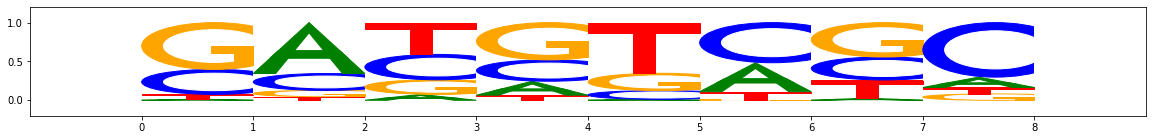

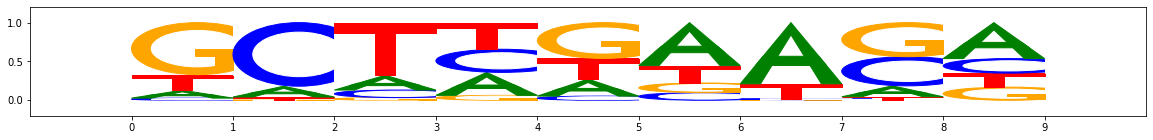

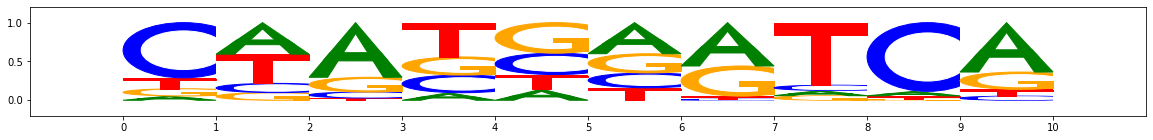

In [1]:
#motifs of varying lengths
#and of varying frequencies

import numpy as np
from modisco.visualization import viz_sequence

rng = np.random.RandomState(1234)

def generate_ppm(rng, length, alpha):
    return rng.dirichlet(alpha*np.ones(4), size=length)

motif1 = generate_ppm(rng, length=5, alpha=0.5)
viz_sequence.plot_weights(motif1)

motif2 = generate_ppm(rng, length=6, alpha=0.6)
viz_sequence.plot_weights(motif2)

motif3 = generate_ppm(rng, length=7, alpha=0.7)
viz_sequence.plot_weights(motif3)

motif4 = generate_ppm(rng, length=8, alpha=0.8)
viz_sequence.plot_weights(motif4)

motif5 = generate_ppm(rng, length=9, alpha=0.9)
viz_sequence.plot_weights(motif5)

motif6 = generate_ppm(rng, length=10, alpha=1.0)
viz_sequence.plot_weights(motif6)

In [2]:
!pip uninstall -y simdna
%cd /content/
!rm -rf simdna
!git clone https://github.com/kundajelab/simdna.git
%cd /content/simdna
!git checkout dev
!git log -1
!pip install .
%cd /content/

from importlib import reload
%load_ext autoreload
%autoreload 2

Found existing installation: simdna 0.5.0.0
Uninstalling simdna-0.5.0.0:
  Successfully uninstalled simdna-0.5.0.0
/content
Cloning into 'simdna'...
remote: Enumerating objects: 1204, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 1204 (delta 145), reused 216 (delta 88), pack-reused 894
Receiving objects: 100% (1204/1204), 4.01 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (673/673), done.
/content/simdna
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 0e497659680c1ae3e635d8bcd4b50fb58b20dd17 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Sep 15 15:43:01 2021 -0700

    bugfix
Processing /content/simdna
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new beh

In [3]:
motifs = [motif1, motif2, motif3, motif4, motif5, motif6]

In [8]:
#generate simulate sequences
from importlib import reload
import simdna
reload(simdna.synthetic.substringgen)
#reload(simdna.synthetic.embedders)
from simdna.simdnautil.pwm import PWM
import simdna.synthetic as sn
import simdna

rng = np.random.RandomState(1234)

simdnapwmembedders = [sn.SubstringEmbedder(sn.PwmSampler(
                       PWM(name="motif"+str(idx),probMatrix=motif,
                           pseudocountProb=0.0)))
                      for idx,motif in enumerate(motifs)]
relative_probs = rng.dirichlet(alpha=np.ones(len(motifs))*5)
print("Motif relative probs:", relative_probs)
embedder = sn.RandomSubsetOfEmbedders(
              quantityGenerator=3, embedders=simdnapwmembedders,
              probs=relative_probs)
simulator = sn.EmbedInABackground(
    backgroundGenerator=sn.ZeroOrderBackgroundGenerator(
        seqLength=200,
        discreteDistribution={'A':0.27, 'C':0.23, 'G':0.23, 'T': 0.27}),
        embedders=[embedder])

sn.print_sequences(
    outputFileName="mysim.simdna",
    sequenceSetGenerator=sn.GenerateSequenceNTimes(simulator, N=1000),
    includeEmbeddings=True)

Motif relative probs: [0.23573248 0.10384039 0.13407845 0.28060085 0.19234588 0.05340196]


In [107]:
bgsimulator = sn.EmbedInABackground(
    backgroundGenerator=sn.ZeroOrderBackgroundGenerator(
        seqLength=200,
        discreteDistribution={'A':0.27, 'C':0.23, 'G':0.23, 'T': 0.27}),
        embedders=[])

sn.print_sequences(
    outputFileName="bgsim.simdna",
    sequenceSetGenerator=sn.GenerateSequenceNTimes(bgsimulator, N=1000),
    includeEmbeddings=True)

In [9]:
!ls

mysim_info.txt	mysim.simdna  sample_data  simdna


In [108]:
simdata = sn.read_simdata_file("mysim.simdna")
bgdata = sn.read_simdata_file("bgsim.simdna")

In [113]:
seqs = simdata.sequences

#one-hot encode the seqs
import numpy as np
lookup = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
def onehotencode_seqs(seqs):
  to_return = []
  for seq in seqs:
    to_return.append([lookup[letter] for letter in seq])
  return np.array(to_return)

fg_onehot_seqs = onehotencode_seqs(simdata.sequences)
bg_onehot_seqs = onehotencode_seqs(bgdata.sequences)

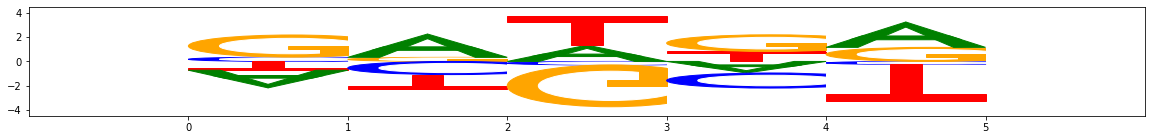

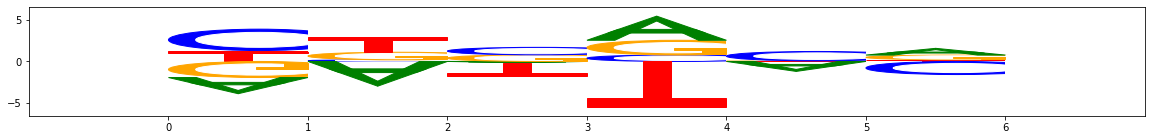

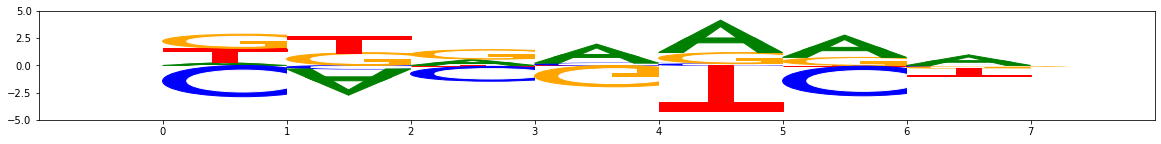

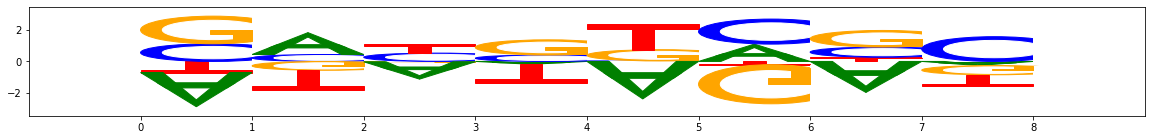

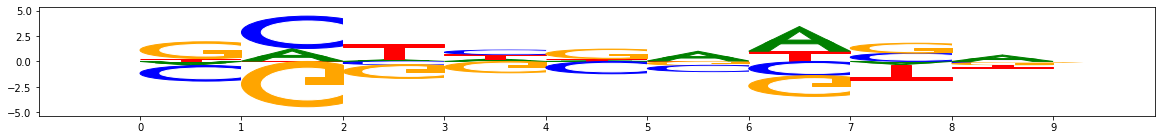

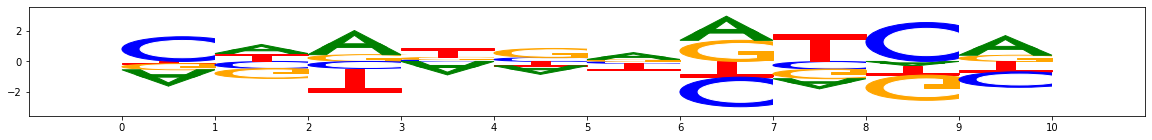

In [141]:
#score each sequence with the log-odds matrix of each pfm
background = np.array([0.27, 0.23, 0.23, 0.27])
pwms = [np.log(motif/background) for motif in motifs]
for pwm in pwms:
  viz_sequence.plot_weights(pwm - np.mean(pwm, axis=-1)[:,None])

In [115]:
#scan each sequence with the rolling window sums. 
import modisco
import scipy

def scan_sequences(onehot_seqs):
  mu = -4
  expfactor = 3
  logodds_scans = []
  pwm_scans = []
  for pwm in pwms:
    logodds_scans.append(modisco.util.compute_pwm_scan(onehot_seq=onehot_seqs,
                                                      weightmat=pwm))
    pwm_scans.append( np.exp(expfactor*scipy.special.expit(logodds_scans[-1]+mu)) )
  return logodds_scans, pwm_scans

(fg_logodds_scans, fg_pwm_scans) = scan_sequences(fg_onehot_seqs)
(bg_logodds_scans, bg_pwm_scans) = scan_sequences(bg_onehot_seqs)

In [116]:
print("hits in fg")
for logodds_scan in fg_logodds_scans:
  print(np.sum(logodds_scan+mu > 0)) #instances of "positive" hits

print("hits in bg")
for logodds_scan in bg_logodds_scans:
  print(np.sum(logodds_scan+mu > 0)) #instances of "positive" hits

hits in fg
787
335
822
763
868
646
hits in bg
629
320
597
546
599
535


In [117]:
def find_imp(onehot_seqs, pwm_scans, logodds_scans):
  ref = np.exp(expfactor*scipy.special.expit(mu))
  simulated_hyp_scores = np.zeros_like(onehot_seqs, dtype="float64")
  for rowidx in range(len(pwm_scans[0])):
    for pwm,scan,logodds_scan in zip(pwms, pwm_scans, logodds_scans):
      for startidx, score in enumerate(scan[rowidx]):
        diff_from_ref = score-ref
        if (True):
          #print(diff_from_ref)
          total_logodds = logodds_scan[rowidx][startidx]
          assert np.sign(diff_from_ref)==np.sign(total_logodds)
          scalefactor = diff_from_ref/total_logodds
          simulated_hyp_scores[rowidx][startidx:startidx+len(pwm)] += pwm*scalefactor
  simulated_actual_scores = simulated_hyp_scores*onehot_seqs

  return simulated_hyp_scores, simulated_actual_scores

fg_hyp_scores, fg_actual_scores = find_imp(fg_onehot_seqs, fg_pwm_scans,
                                           fg_logodds_scans)

bg_hyp_scores, bg_actual_scores = find_imp(bg_onehot_seqs, bg_pwm_scans,
                                           bg_logodds_scans)

fg


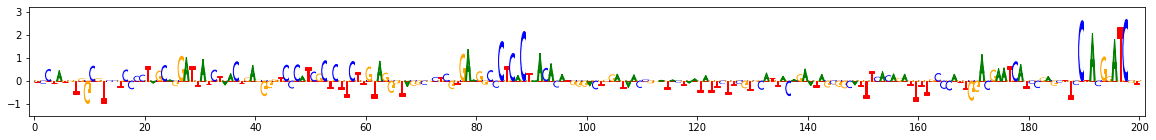

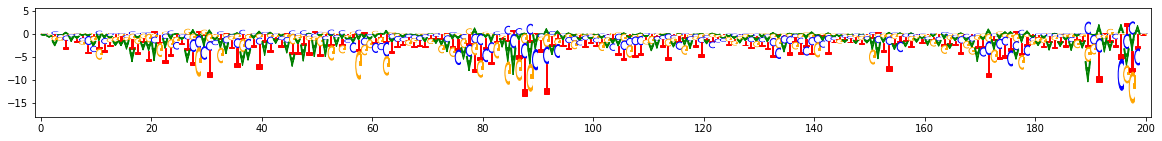

fg


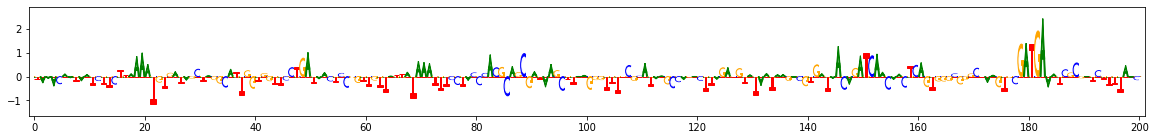

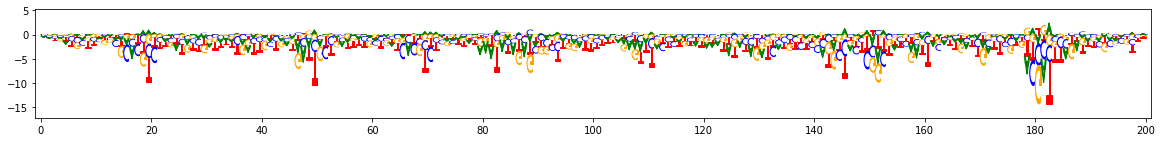

fg


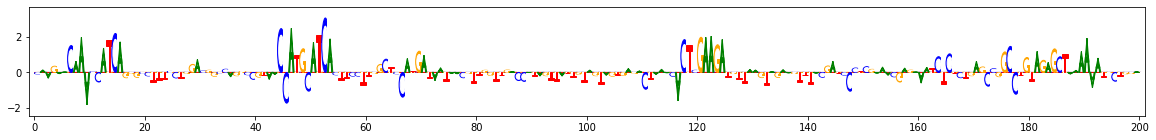

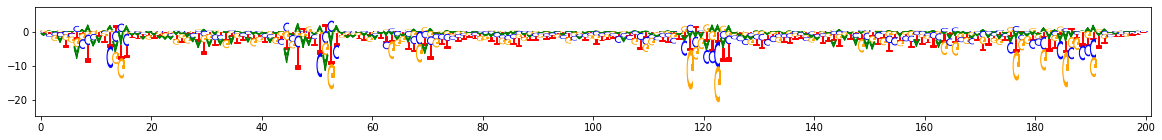

fg


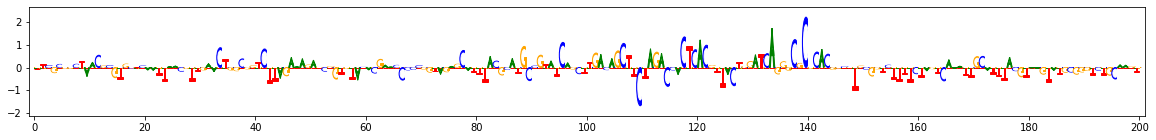

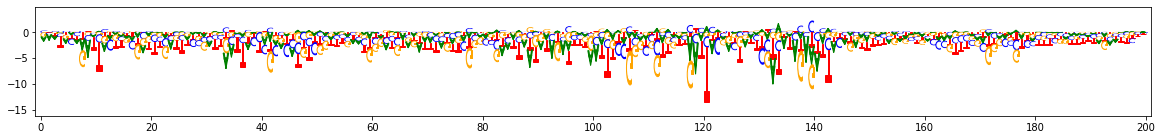

fg


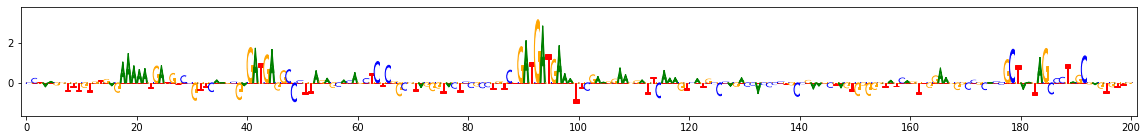

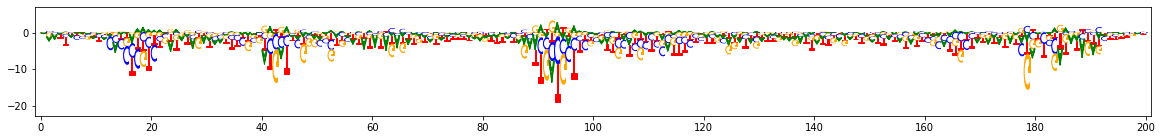

In [119]:
from modisco.visualization import viz_sequence

for i in range(5):
  print("fg")
  viz_sequence.plot_weights(fg_actual_scores[i], subticks_frequency=20)
  viz_sequence.plot_weights(fg_hyp_scores[i], subticks_frequency=20)
  #print("bg")
  #viz_sequence.plot_weights(bg_actual_scores[i], subticks_frequency=20)
  #viz_sequence.plot_weights(bg_hyp_scores[i], subticks_frequency=20)

MEMORY 0.600547328
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
For increasing = True , the minimum IR precision was 0.0 occurring at 1.5536635071811133e-06 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.0 occurring at -1.169329784866946e-05 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -6.954979193558271  and  30.555385687836438 with frac passing 0.00010555555555555555
Passing windows frac was 0.00010555555555555555 , which is below  0.03 ; adjusting
Final raw thresholds are -13.405949519454035  and  13.405949519454035
Final transformed thresholds are -0.97  and  0.97


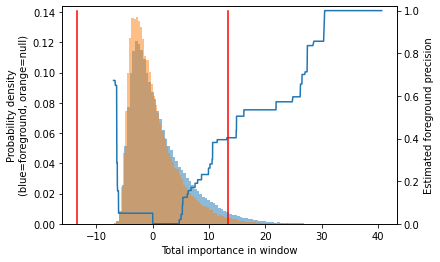

Got 472 coords
After resolving overlaps, got 472 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699
MEMORY 0.600608768
472 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [472]
Idx to activities:  {0: '1'}
MEMORY 0.600608768
On metacluster 0
Metacluster size 472
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 472
(Round 1) Computing coarse affmat
MEMORY 0.600608768
Beginning embedding computation
MEMORY 0.600608768


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   21.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   43.4s
[Parallel(n_jobs=10)]: Done 472 out of 472 | elapsed:   47.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   38.2s
[Parallel(n_jobs=10)]: Done 472 out of 472 | elapsed:   42.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 472 out of 472 | elapsed:    1.7s finished


Constructing csr matrix...
csr matrix made in 0.14741277694702148 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 472 out of 472 | elapsed:    1.8s finished


Constructing csr matrix...
csr matrix made in 0.13044118881225586 s
Finished embedding computation in 93.81 s
MEMORY 0.635654144
Starting affinity matrix computations
MEMORY 0.635654144
Batching in slices of size 472


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Finished affinity matrix computations in 1.58 s
MEMORY 1.770958848
(Round 1) Computed coarse affmat
MEMORY 1.769648128
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 1.769648128


Launching nearest neighbors affmat calculation job
MEMORY 1.769648128
Parallel runs completed
MEMORY 1.769746432
Job completed in: 32.46 s
MEMORY 1.769484288
Launching nearest neighbors affmat calculation job
MEMORY 1.769484288
Parallel runs completed
MEMORY 1.769422848
Job completed in: 32.3 s
MEMORY 1.769422848
(Round 1) Computed affinity matrix on nearest neighbors in 65.1 s
MEMORY 1.769365504
Filtered down to 472 of 472
(Round 1) Retained 472 rows out of 472 after filtering
MEMORY 1.769230336
(Round 1) Computing density adapted affmat
MEMORY 1.769230336
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 1.768886272
Beginning preprocessing + Leiden
Affmat shape: 472


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.0s


Quality: 0.023524447448216447
Got 4 clusters after round 1
Counts:
{1: 133, 0: 134, 2: 111, 3: 94}
MEMORY 1.769455616
(Round 1) Aggregating seqlets in each cluster
MEMORY 1.769455616
Aggregating for cluster 0 with 134 seqlets
MEMORY 1.769455616
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.6s finished


Skipped 20 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 113
Skipped 19 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 133 seqlets
MEMORY 1.769455616
Skipped 14 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 119
Skipped 15 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 111 seqlets
MEMORY 1.769455616
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 12 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 97
Skipped 18 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 94 seqlets
MEMORY 1.769455616
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   15.5s
[Parallel(n_jobs=10)]: Done 345 out of 345 | elapsed:   27.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 345 out of 345 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.11164593696594238 s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.2s finished


Constructing csr matrix...
csr matrix made in 0.09591817855834961 s
Finished embedding computation in 55.05 s
MEMORY 1.102544896
Starting affinity matrix computations
MEMORY 1.102544896
Batching in slices of size 345


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

Finished affinity matrix computations in 2.13 s
MEMORY 1.696292864


(Round 2) Computed coarse affmat
MEMORY 1.695244288
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 1.695244288
Launching nearest neighbors affmat calculation job
MEMORY 1.695301632
Parallel runs completed
MEMORY 1.722486784
Job completed in: 26.35 s
MEMORY 1.721962496
Launching nearest neighbors affmat calculation job
MEMORY 1.721962496
Parallel runs completed
MEMORY 1.721991168
Job completed in: 26.39 s
MEMORY 1.721991168
(Round 2) Computed affinity matrix on nearest neighbors in 53.03 s
MEMORY 1.722064896
Not applying filtering for rounds above first round
MEMORY 1.722064896
(Round 2) Computing density adapted affmat
MEMORY 1.722073088
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 1.721032704
Beginning preprocessing + Leiden
Affmat shape: 345


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.2s


Quality: 0.027307702864010422
Got 4 clusters after round 2
Counts:
{1: 98, 3: 69, 0: 105, 2: 73}
MEMORY 1.721069568
(Round 2) Aggregating seqlets in each cluster
MEMORY 1.721069568
Aggregating for cluster 0 with 105 seqlets
MEMORY 1.721069568


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   16.2s finished


Trimming eliminated 0 seqlets out of 105
Skipped 1 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 98 seqlets
MEMORY 1.721073664
Skipped 2 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 96
Skipped 6 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 73 seqlets
MEMORY 1.721073664
Skipped 1 seqlets that went over the sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 72
Skipped 2 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 69 seqlets
MEMORY 1.721073664
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 67
Skipped 8 seqlets that went over the sequence edge during flank expansion
Got 4 clusters
Splitting into subclusters...
MEMORY 1.721073664
Inspecti

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed:    0.2s


[t-SNE] Computed conditional probabilities for sample 104 / 104
[t-SNE] Mean sigma: 0.366532
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done 104 out of 104 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 104


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.2s


Quality: 0.20595637968695624
Got subclusters: Counter({0: 30, 1: 26, 2: 19, 3: 16, 4: 7, 6: 3, 5: 3})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.4s finished


Numbers for each pattern pre-subsample: [30, 26, 19, 16, 7, 3, 3]
Numbers after subsampling: [30, 26, 19, 16, 7, 3, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.7391283512115479 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.6355044841766357 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.4170501232147217 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.36086559295654297 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.18451452255249023 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.11209487915039062 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.10580825805664062 s
Cluster sizes
[30 26 19 16  7  3  3]
Cross-contamination matrix:
[[1.   0.24 0.66 0.38 0.53 0.08 0.31]
 [0.93 1.   1.   0.93 0.99 0.62 0.71]
 [0.7  0.4  1.   0.52 0.82 0.1  0.36]
 [0.68 0.48 0.81 1.   0.78 0.12 0.48]
 [0.09 0.02 0.2  0.07 1.   0.   0.02]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.35 0.15 0.3  

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s


[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 0.392184
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 90


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s


Quality: 0.16840906768142916
Got subclusters: Counter({0: 27, 1: 23, 2: 16, 3: 13, 4: 8, 5: 3})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.2s finished


Numbers for each pattern pre-subsample: [27, 23, 16, 13, 8, 3]
Numbers after subsampling: [27, 23, 16, 13, 8, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.5557081699371338 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.45515942573547363 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.3069279193878174 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.27124881744384766 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.1692202091217041 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.09920787811279297 s
Cluster sizes
[27 23 16 13  8  3]
Cross-contamination matrix:
[[1.   0.49 0.28 0.44 0.31 0.17]
 [0.78 1.   0.58 0.8  0.46 0.57]
 [0.9  0.93 1.   0.92 0.61 0.76]
 [0.64 0.71 0.43 1.   0.33 0.33]
 [0.5  0.39 0.27 0.35 1.   0.25]
 [0.01 0.05 0.01 0.   0.02 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.84 0.8  0.8  0.74 0.59]
 [0.84 1.   0.9  0.91 0.73 0.68]
 [0.8  0.9  1.   0.88 0.7  0.65]
 [0.8  

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 70


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.6s


Quality: 0.10806538811602698
Quality: 0.10859889520051015
Quality: 0.10908702137545588
Got subclusters: Counter({0: 23, 1: 19, 2: 16, 3: 12})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.6s finished


Numbers for each pattern pre-subsample: [23, 19, 16, 12]
Numbers after subsampling: [23, 19, 16, 12]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.28376197814941406 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.20520639419555664 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.18288064002990723 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.15648531913757324 s
Cluster sizes
[23 19 16 12]
Cross-contamination matrix:
[[1.   0.33 0.56 0.66]
 [0.91 1.   0.8  0.97]
 [0.79 0.51 1.   0.85]
 [0.56 0.32 0.54 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.88 0.88 0.87]
 [0.88 1.   0.84 0.86]
 [0.88 0.84 1.   0.88]
 [0.87 0.86 0.88 1.  ]]
Collapsing 2 & 3 with crosscontam 0.541087962962963 and sim 0.880765163870421
Collapsing 0 & 2 with crosscontam 0.5641283800443821 and sim 0.8764602472061827
Collapsing 0 & 3 with crosscontam 0.5588768115942029 and sim 0.866169044999261
Trimming eliminated 0 seqlets out of 28
Trimming eliminated 0

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  59 out of  59 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s


Quality: 0.08322899173044548
Got subclusters: Counter({0: 28, 1: 19, 2: 12})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    9.9s finished


Numbers for each pattern pre-subsample: [28, 19, 12]
Numbers after subsampling: [28, 19, 12]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.23044085502624512 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.1446239948272705 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.11096835136413574 s
Cluster sizes
[28 19 12]
Cross-contamination matrix:
[[1.   0.55 0.97]
 [0.57 1.   0.76]
 [0.47 0.28 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.67 0.81]
 [0.67 1.   0.72]
 [0.81 0.72 1.  ]]
Merging on 12 clusters
MEMORY 1.72132352
On merging iteration 1
Numbers for each pattern pre-subsample: [91, 7, 3, 3, 52, 27, 8, 3, 66, 28, 19, 12]
Numbers after subsampling: [91, 7, 3, 3, 52, 27, 8, 3, 66, 28, 19, 12]
Computing sims for pattern 0
Computed sims for pattern 0 in 4.306962013244629 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.3843719959259033 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.24477601051330566 s
Comput

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  91 out of  91 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 90 nearest neighbors...
[t-SNE] Indexed 91 samples in 0.009s...
[t-SNE] Computed neighbors for 91 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 91 / 91
[t-SNE] Mean sigma: 0.372695
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 50.5543442, gradient norm = 0.5775127 (50 iterations in 0.032s)
[t-SNE] Iteration 100: error = 49.8650970, gradient norm = 0.5236782 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 49.7280579, gradient norm = 0.4682925 (50 iterations in 0.027s)
[t-SNE] Iteration 200: error = 50.9037819, gradient norm = 0.5141151 (50 iterations in 0.025s)
[t-SNE] Iteration 250: error = 50.7292862, gradient norm = 0.4392403 (50 iterations in 0.027s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.729286
[t-SNE] Iteration 300: error = 0.7341303, gradient norm = 0.0083545 (50 iterations in 0.026s)
[t-SNE] Iteration 350: error = 0.3438898, gradient norm = 0.0223629 (50 i

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.7s


Quality: 0.17833873013619864


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  66 out of  66 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


Got subclusters: Counter({0: 24, 1: 22, 2: 17, 3: 16, 4: 12})
On pattern 1
[t-SNE] Computing 65 nearest neighbors...
[t-SNE] Indexed 66 samples in 0.001s...
[t-SNE] Computed neighbors for 66 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 0.469656
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 47.4286575, gradient norm = 0.5619931 (50 iterations in 0.031s)
[t-SNE] Iteration 100: error = 48.4469452, gradient norm = 0.4556771 (50 iterations in 0.020s)
[t-SNE] Iteration 150: error = 48.4356270, gradient norm = 0.5208896 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 48.3948898, gradient norm = 0.6934571 (50 iterations in 0.018s)
[t-SNE] Iteration 250: error = 51.0808182, gradient norm = 0.5317791 (50 iterations in 0.027s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.080818
[t-SNE] Iteration 300: error = 0.9749130, gradient norm = 0.0016139 (50 iterations in 0.019s

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s


Quality: 0.08680577850094755


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 out of  52 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


Got subclusters: Counter({1: 20, 0: 20, 2: 13, 3: 13})
On pattern 2
[t-SNE] Computing 51 nearest neighbors...
[t-SNE] Indexed 52 samples in 0.002s...
[t-SNE] Computed neighbors for 52 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 52 / 52
[t-SNE] Mean sigma: 0.909282
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 49.7711792, gradient norm = 0.6191928 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 45.6320801, gradient norm = 0.6551185 (50 iterations in 0.016s)
[t-SNE] Iteration 150: error = 42.5225601, gradient norm = 0.4946559 (50 iterations in 0.027s)
[t-SNE] Iteration 200: error = 41.9331093, gradient norm = 0.4602119 (50 iterations in 0.028s)
[t-SNE] Iteration 250: error = 41.4184532, gradient norm = 0.4369469 (50 iterations in 0.035s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.418453
[t-SNE] Iteration 300: error = 0.7641418, gradient norm = 0.0012378 (50 iterations in 0.017s)
[t-SN

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.6s


Quality: 0.008366228325763381
Quality: 0.00837804419304784
Quality: 0.00840395697144507
Quality: 0.008541772964165627
Quality: 0.008642027536622134
Quality: 0.008765134446659594
Got subclusters: Counter({0: 32, 1: 20})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.4s finished


In [120]:
import modisco

#null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
null_per_pos_scores = {"task0":np.sum(bg_actual_scores,axis=-1)}
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    target_seqlet_fdr=0.05,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        final_flank_to_add=5,
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores={"task0": fg_actual_scores},
                 hypothetical_contribs={"task0": fg_hyp_scores},
                 one_hot=fg_onehot_seqs,
                 null_per_pos_scores=null_per_pos_scores)

In [133]:
patterns = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.patterns

In [134]:
remaining_patterns = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.remaining_patterns

seqlets: 91


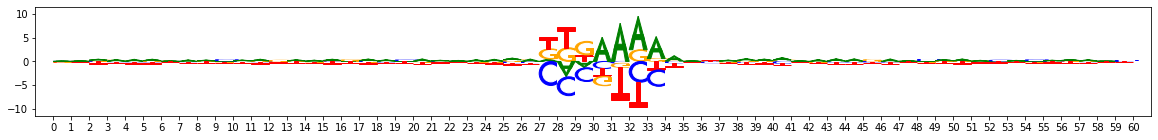

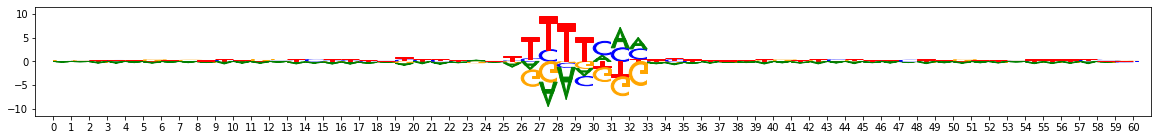

seqlets: 66


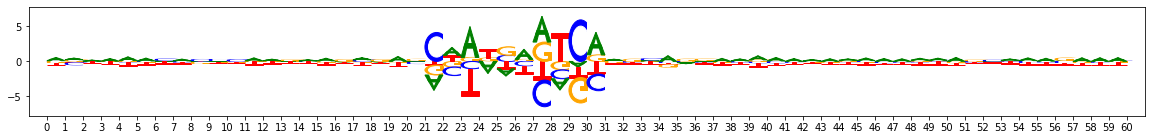

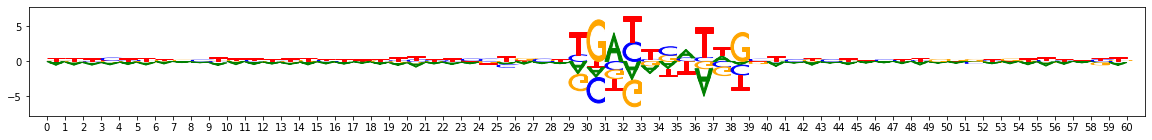

seqlets: 52


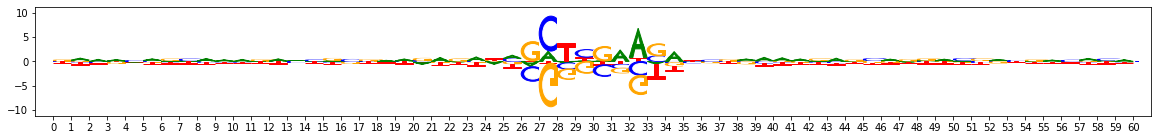

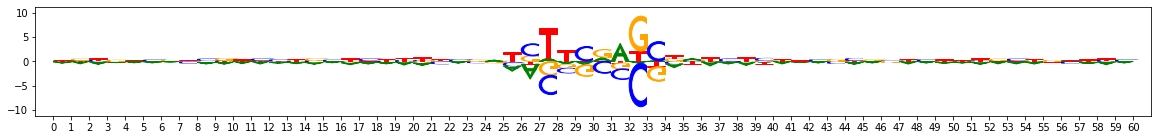

In [140]:
for pattern in patterns:
  print("seqlets:", len(pattern.seqlets))
#  viz_sequence.plot_weights(pattern["sequence"].fwd)
#  viz_sequence.plot_weights(pattern["sequence"].rev)
#  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd
                            - np.mean(pattern["task0_hypothetical_contribs"].fwd, axis=-1)[:,None])
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev
                               - np.mean(pattern["task0_hypothetical_contribs"].rev, axis=-1)[:,None])

Metaclusters heatmap


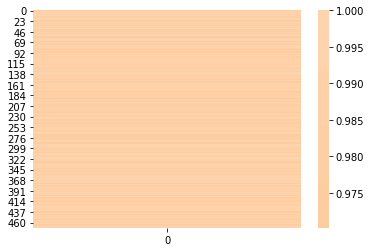

NameError: ignored